In [ ]:
import os

# this get our current location in the file system
import inspect
HERE_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))

In [2]:
import numpy as np

In [3]:
import tools
from continuous import ContinuousPlayer
from continuous import ContinuousLearner

In [4]:
def signal_generator_2D(is_target_flashed):
    cov = [[0.1, 0], [0, 0.1]]
    if is_target_flashed:
        mean = [0, 0]
    else:
        mean = [1, 1]
    return np.random.multivariate_normal(mean, cov, 1)[0].tolist()

In [5]:
N_HYPOTHESIS = 10
TARGET = None

for i in range(2, 3):

    seed = i
    tools.set_seed(seed)

    print('{}/{}'.format(i+1, 100))

    player = ContinuousPlayer(N_HYPOTHESIS, signal_generator_2D, TARGET)
    learner = ContinuousLearner(N_HYPOTHESIS, proba_decision_threshold=0.95, proba_assigned_to_label_valid=0.95)

    N_FOUND = 5

    run_info = {}
    run_info['steps_to_solved'] = []
    run_info['valid'] = []
    for j in range(100):
        # flash_pattern = learner.get_next_flash_pattern(planning_method='even_random')
        flash_pattern = learner.get_next_flash_pattern(planning_method='even_uncertainty')
        feedback_signal = player.get_feedback_signal(flash_pattern)
        learner.update(flash_pattern, feedback_signal)

        if learner.is_solved():
            true_i_target = player.target_index
            found_i_target = learner.get_solution_index()
            print('{} - {} in {} steps'.format(true_i_target, found_i_target, j+1))
            valid = true_i_target == found_i_target
            run_info['valid'].append(valid)

            run_info['steps_to_solved'].append(j+1)
            if len(run_info['steps_to_solved']) >= N_FOUND:
                break

            # change target and propagate label for next target
            player.update_target_index()
            learner.propagate_labels_from_hypothesis(found_i_target)

Setting seed to 2
3/100
8 - 8 in 8 steps
5 - 5 in 14 steps
2 - 2 in 19 steps
5 - 5 in 24 steps
3 - 3 in 28 steps


In [6]:
import matplotlib
import matplotlib.pyplot as plt
plt.ion()

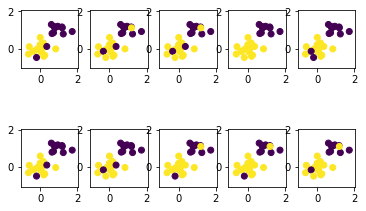

In [7]:
##
fig = plt.figure()
X = np.array(learner.signal_history)
for i_hyp in range(N_HYPOTHESIS):
    y = learner.hypothesis_labels[i_hyp]
    ax = plt.subplot(2, 5, i_hyp+1)
    ax.scatter(X[:,0], X[:,1], c=y)

    delta = 0.05
    ax.set_aspect('equal')
    ax.set_xlim([- 1 - delta, 2 + delta])
    ax.set_ylim([- 1 - delta, 2 + delta])

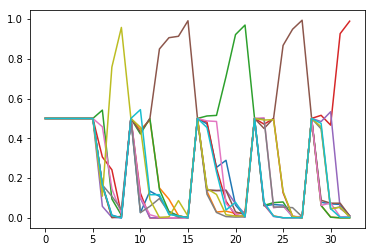

In [8]:
#
fig = plt.figure()
plt.plot(learner.hypothesis_probability_history)

In [9]:
learner.get_logs()

{'learner_type': 'continuous',
 'n_hypothesis': 10,
 'use_leave_one_out': False,
 'proba_decision_threshold': 0.95,
 'proba_assigned_to_label_valid': 0.95,
 'hypothesis_probability_history': [[0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [0.16582751221373493,
   0.16582751221373493,
   0.5417606508759037,
   0.3062301772208649,
   0.05820161223519678,
   0.16587431655046508,
   0.45823934912409625,
   0.16585720950793237,
   0.10921615332658392,
   0.16587241263760208],
  [0.013942690356584428,
   0.002150041107489125,
   0.09519665130028718,
   0.24199752711878972,
   0.0026638542129018995,
   0.0018439444114902353,
   0.1464460957151269,
   0.10856459936638624,
   0.7580024728812103,


In [9]:
# code below is used to test the plotting of clasifer map for web display
# adding openvault_web/server directory to path
import sys
openvault_web_path = os.path.join(HERE_PATH, '..', 'openvault_web', 'server')
sys.path.append(openvault_web_path)
import web_tools

solution = learner.get_solution_index()
clf = learner.hypothesis_classifier_infos[solution]['clf']
y_img = web_tools.generate_map_from_classifier(clf, bounds=(-5, 5))

web_tools.save_map_to_file(y_img, 'classifier_boundaries.png', fig_width_inches=5)

signal_scaled, scaler = web_tools.scale_data_to_view_windows(learner.signal_history)

map_grid = web_tools.generate_map_from_classifier(clf, scaler=scaler)

web_tools.save_map_to_file(map_grid, 'classifier_boundaries_scaled.png', fig_width_inches=5)